In [1]:
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix, bmat, eye
from scipy.sparse import random, block_diag, diags
from networkx.algorithms import bipartite
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from heapq import nlargest
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

Code originated from https://github.com/yaremenko8/FAST_PSEUDOINVERSE

### Matrix Reordering

In [2]:
#Build Bipartite Network
def to_graph(A):
    return bipartite.matrix.from_biadjacency_matrix(A)

#get giant connected component
def gcc(graph):
    return graph.subgraph(max(nx.connected_components(graph), key=len))

#get the top nodes and bottom nodes
def top_bottom(graph):
    top_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 0}
    bottom_nodes = set(graph) - top_nodes
    return top_nodes, bottom_nodes

#get the feature nodes and instance nodes
def largest_hubs(graph, k=0.2):
    top, bottom = top_bottom(graph)
    m_top = max(1, int(len(top) * k))
    m_bot = max(1, int(len(bottom) * k))
    degree = lambda x: graph.degree[x]
    top_largest = nlargest(m_top, top, key=degree)
    bottom_largest = nlargest(m_bot, bottom, key=degree)
    return top_largest, bottom_largest

#remove the feature hub and instance hub from graph
def reduce(graph, k=0.2):
    top_largest, bottom_largest = largest_hubs(graph, k)
    graph.remove_nodes_from(top_largest + bottom_largest)
    new_graph = gcc(graph).copy()
    graph.remove_nodes_from(new_graph.nodes())
    print(len(graph), len(new_graph), len(top_largest + bottom_largest))
    return (*top_bottom(graph), new_graph, top_largest, bottom_largest)

#### permutation algorithm
<img src='pics/permutation.png'>

In [3]:
def permute(A, k=0.2):
    graph = to_graph(A)
    top, bottom = top_bottom(graph)
    #define the number of m feature hubs and n instance hubs
    m_top = max(1, int(len(top) * k))
    m_bot = max(1, int(len(bottom) * k))
    nt = []
    nb = []
    perm_top_lhs = []
    perm_top_rhs = []
    perm_bot_lhs = []
    perm_bot_rhs = []
    while m_top < len(top) and m_bot < len(bottom):
        m_top = max(1, int(len(top) * k))
        m_bot = max(1, int(len(bottom) * k))
        #reduce  m feature hubs and n instance hubs in original grapgh G
        ptl, pbl, graph, ptr, pbr = reduce(graph, k)
        perm_top_lhs = perm_top_lhs + list(ptl)
        perm_bot_lhs = perm_bot_lhs + list(pbl)
        perm_top_rhs = list(ptr) + perm_top_rhs
        perm_bot_rhs = list(pbr) + perm_bot_rhs
        nt.append(len(perm_top_lhs))
        nb.append(len(perm_bot_lhs))
        #renew the number of top/bottom
        top, bottom = top_bottom(graph)
    perm_top = np.array(perm_top_lhs + list(top) + perm_top_rhs)
    perm_bot = np.array(perm_bot_lhs + list(bottom) + perm_bot_rhs) - A.shape[0]
    #return the new A
    return A[perm_top].T[perm_bot].T, perm_top, perm_bot, nt + [len(perm_top_lhs)], nb + [len(perm_bot_lhs)]

200 1700 100
87 1529 84
204 1249 76
262 925 62
614 265 46
153 100 12
56 40 4
20 18 2
9 7 2
2 3 2
[97, 139, 242, 374, 688, 762, 788, 798, 803, 804, 804] [103, 148, 249, 379, 679, 758, 788, 798, 802, 803, 803]


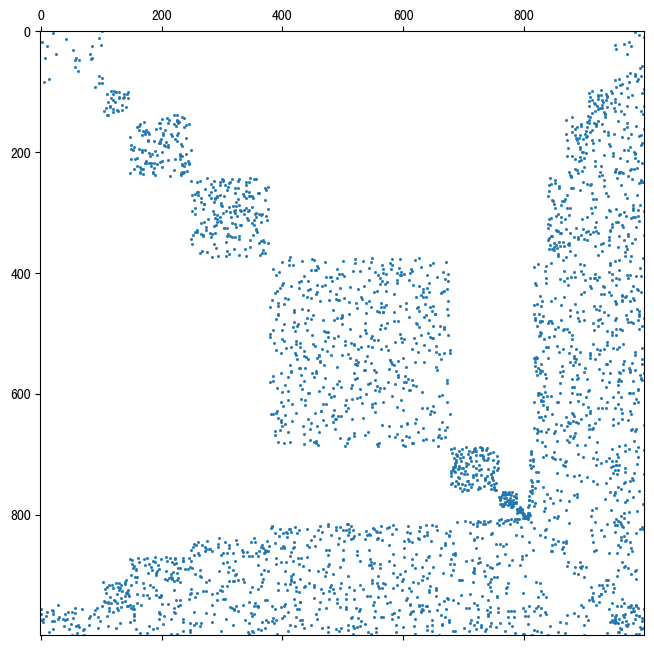

In [4]:
#case study
A = lil_matrix(random(1000, 1000, density=0.003))
B, _, _, nt, nb = permute(A, k = 0.05)
m1, n1 = nt[-1], nb[-1]
print(nt, nb)
plt.figure()
plt.spy(B, markersize=1)
plt.show()

After reorder $A$, divide $A$ into $\left[\begin{array}{ll}\mathbf{A}_{11} & \mathbf{A}_{12} \\ \mathbf{A}_{21} & \mathbf{A}_{22}\end{array}\right]$

In [5]:
def get_permuted_blocks(A, k=0.2):
    B, perm_top, perm_bot, nt, nb = permute(A, k)
    m1, n1 = nt[-1], nb[-1]
    A_11 = B[:m1, :n1]
    A_21 = B[m1:, :n1]
    T = B[:, n1:]
    return A_11, A_21, T, nt, nb, perm_top, perm_bot

SVD result of $A_{11}$:
\begin{equation}
\begin{aligned}
\mathbf{U}_{m_{1} \times s} \boldsymbol{\Sigma}_{s \times s} \mathbf{V}_{s \times n_{1}}^{\top}=& \operatorname{bdiag}\left(\mathbf{U}^{(1)}, \cdots, \mathbf{U}^{(B)}\right) \times \\
& \operatorname{bdiag}\left(\boldsymbol{\Sigma}^{(1)}, \cdots, \boldsymbol{\Sigma}^{(B)}\right) \times \operatorname{bdiag}\left(\mathbf{V}^{(1) \top}, \cdots, \mathbf{V}^{(B) \top}\right)
\end{aligned}
\end{equation}

In [6]:
def phase1(A_11, nt, nb, alpha):
    U_blocks = []
    S_blocks = []
    VT_blocks = []
    i0 = 0
    j0 = 0
    for i1, j1 in zip(nt, nb):
        if i1 == i0 and j1 == j0:
            continue
        m = i1 - i0
        n = j1 - j0
        s = int(np.ceil(min(m, n) * alpha))
        U_, S_, VT_ = svds(A_11[i0: i1, j0: j1], k=s)
        U_blocks.append(U_)
        S_blocks.append(diags(S_))
        VT_blocks.append(VT_)
        i0 = i1
        j0 = j1
    U = block_diag(U_blocks)
    S = block_diag(S_blocks)
    VT = block_diag(VT_blocks)
    return U, S, VT

SVD result of $[A_{11};A_{21}]$
\begin{equation}
\begin{aligned}
{\left[\begin{array}{l}
\mathbf{A}_{11} \\
\mathbf{A}_{21}
\end{array}\right] } & \simeq\left[\begin{array}{c}
\mathbf{U}_{m_{1} \times s} \boldsymbol{\Sigma}_{s \times s} \mathbf{V}_{s \times n_{1}}^{\top} \\
\mathbf{A}_{21}
\end{array}\right] \\
&=\left[\begin{array}{c}
\mathbf{U}_{m_{1} \times s} \mathbf{O}_{m_{1} \times m_{2}} \\
\mathbf{O}_{m_{2} \times s} \mathbf{I}_{m_{2} \times m_{2}}
\end{array}\right]\left[\begin{array}{c}
\boldsymbol{\Sigma}_{s \times s} \mathbf{V}_{s \times n_{1}}^{\top} \\
\mathbf{A}_{21}
\end{array}\right] \\
& \simeq\left[\begin{array}{c}
\mathbf{U}_{m_{1} \times s} \mathbf{O}_{m_{1} \times m_{2}} \\
\mathbf{O}_{m_{2} \times s} \mathbf{I}_{m_{2} \times m_{2}}
\end{array}\right] \underbrace{\tilde{\mathbf{U}}_{\left(s+m_{2}\right) \times s} \tilde{\boldsymbol{\Sigma}}_{s \times s} \tilde{\mathbf{V}}_{s \times n_{1}}^{\top}}_{\text {Low-rank approximation with } s} \\
&=\mathbf{U}_{m \times s} \boldsymbol{\Sigma}_{s \times s} \mathbf{V}_{s \times n_{1}}^{\top}
\end{aligned}
\end{equation}

In [7]:
def phase2(U, S, VT, A_21):
    s = S.shape[0]
    #print(VT.shape, A_21.shape)
    rhs = bmat([[S @ VT], [A_21]], format='csr')
    lhs = block_diag([U, eye(A_21.shape[0], format='lil')], format='csr')
    #print(type(svds(rhs, k=s)[0]))
    U_ = lhs @ svds(rhs, k=s)[0]
    return U_, S, VT

Incrementally update the SVD result for $[A_{12};A_{22}]$
\begin{equation}
\begin{aligned}
{\left[\begin{array}{l}
\mathbf{A}_{11} \mathbf{A}_{12} \\
\mathbf{A}_{21} \mathbf{A}_{22}
\end{array}\right] } & \simeq\left[\mathbf{U}_{m \times s} \boldsymbol{\Sigma}_{s \times s} \mathbf{V}_{s \times n_{1}}^{\top} \mathbf{T}\right] \\
&=\left[\mathbf{U}_{m \times s} \boldsymbol{\Sigma}_{s \times s} \mathbf{T}\right]\left[\begin{array}{c}
\mathbf{V}_{s \times n_{1}}^{\top} \mathbf{O}_{s \times n_{2}} \\
\mathbf{O}_{n_{2} \times n_{1}} \mathbf{I}_{n_{2} \times n_{2}}
\end{array}\right] \\
&=\underbrace{\tilde{\mathbf{U}}_{m \times r} \tilde{\boldsymbol{\Sigma}}_{r \times r} \tilde{\mathbf{V}}_{r \times\left(s+n_{2}\right)}^{\top}}_{\text {Low-rank approximation with } r}\left[\begin{array}{c}
\mathbf{V}_{s \times n_{1}}^{\top} \mathbf{O}_{s \times n_{2}} \\
\mathbf{O}_{n_{2} \times n_{1}} \mathbf{I}_{n_{2} \times n_{2}}
\end{array}\right] \\
&=\mathbf{U}_{m \times r} \boldsymbol{\Sigma}_{r \times r} \mathbf{V}_{r \times n}^{\top}
\end{aligned}
\end{equation}

In [8]:
def phase3(U, S, VT, T, alpha):
    rhs = block_diag([VT, eye(T.shape[1], format='lil')], format='csc')
    lhs = bmat([[U @ S, T]])
    r = int(np.ceil(min(*lhs.shape) * alpha))
    U_, S_, VT_ = svds(lhs, k=r)
    return U_, S_, VT_ @ rhs

### FastPI algorithm
<img src='pics/fastpi.png'>

In [9]:
def FastPI(A, alpha=0.2, k=0.05):
    A_11, A_21, T, nt, nb, perm_top, perm_bot = get_permuted_blocks(A, k=0.2)
    U, S, VT = phase1(A_11, nt, nb, alpha)
    U, S, VT = phase2(U, S, VT, A_21)
    U, S, VT = phase3(U, S, VT, T, alpha)
    Sinv = 1 / S
    Sinv[Sinv != Sinv] = 0
    return VT.T @ diags(Sinv) @ U.T, perm_top, perm_bot

In [10]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

def plot_surface_function(x1_, x2_, y_, minmax_values=None, ax=None, zlabel=""):
    x1, x2 = np.meshgrid(x1_, x2_)
    y = np.array([[y_(i, j) for j in x2_] for i in x1_])
    if ax is None:
        fig = plt.figure()
        ax = Axes3D(fig)

        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
        ax.set_zlabel(zlabel)
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in matmul
  


804 796 400
622 16 158
804 796 400
622 16 158
804 796 400
622 16 158


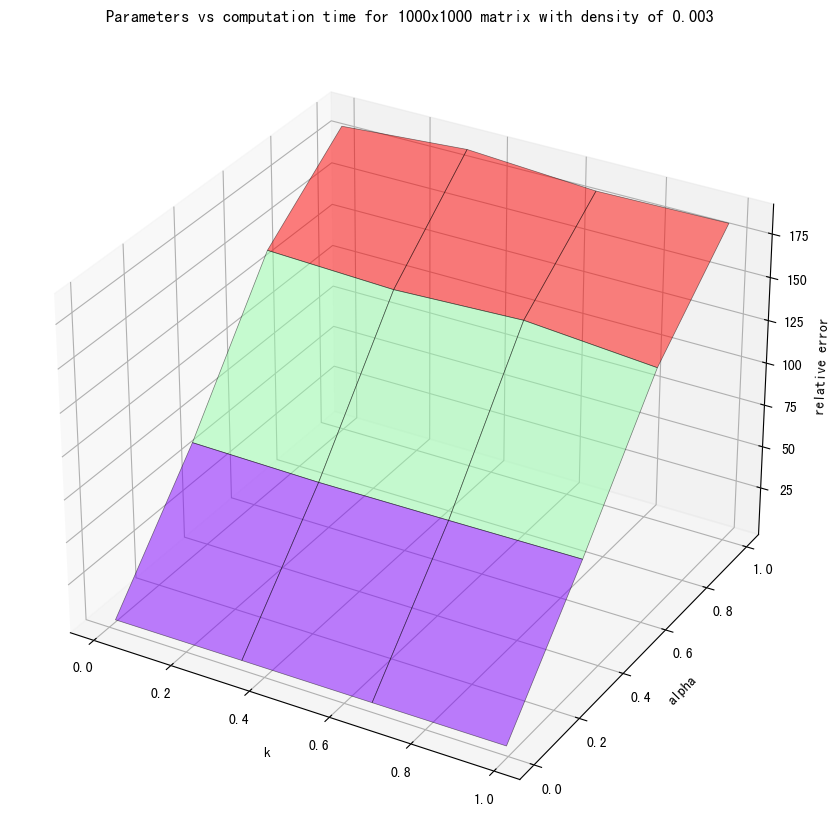

14.782566970214248


In [11]:
#case study
from timeit import timeit

ks = np.linspace(0.01, 0.99, 4, endpoint=True)
alphas = np.linspace(0.01, 0.99, 4, endpoint=True)

def reconstruction_error(x, y):
    Ap, pt, pb = FastPI(A, x, y)
    Ap_ = np.linalg.pinv(A[pt].T[pb].T.todense())
    return np.linalg.norm(Ap - Ap_) / np.linalg.norm(Ap_) 

def elapsed(x, y):
    return timeit("FastPI(A, %f, %f)" % (x, y), globals=globals(), number=1)

plot_surface_function(alphas, ks, elapsed, zlabel="relative error")
plt.xlabel("k")
plt.ylabel("alpha")
plt.title("Parameters vs computation time for 1000x1000 matrix with density of 0.003")
plt.show()
print(timeit("np.linalg.pinv(A.todense())", globals=globals(), number=1))